In [5]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import subprocess


In [6]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [2]:
#Load APA plasmid data (random mpra)
plasmid_dict = pickle.load(open('../../../../aparent/apa_plasmid_data.pickle', 'rb'))

plasmid_df = plasmid_dict['plasmid_df']
plasmid_cuts = plasmid_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)))


len(plasmid_df) = 3810974


In [3]:
#Filter data
kept_libraries = [22]

min_count = 40#50
min_usage = 0.9

if kept_libraries is not None :
    keep_index = np.nonzero(plasmid_df.library_index.isin(kept_libraries))[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_count is not None :
    keep_index = np.nonzero(plasmid_df.total_count >= min_count)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

if min_usage is not None :
    
    prox_c = np.ravel(plasmid_cuts[:, 180+70+6:180+70+6+35].sum(axis=-1))
    total_c = np.ravel(plasmid_cuts[:, 180:180+205].sum(axis=-1)) + np.ravel(plasmid_cuts[:, -1].todense())
    
    keep_index = np.nonzero(prox_c / total_c >= min_usage)[0]
    plasmid_df = plasmid_df.iloc[keep_index].copy()
    plasmid_cuts = plasmid_cuts[keep_index, :]

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (filtered)")


len(plasmid_df) = 95749 (filtered)


In [7]:
#Store cached filtered dataframe
#pickle.dump({'plasmid_df' : plasmid_df, 'plasmid_cuts' : plasmid_cuts}, open('apa_simple_cached_set_large.pickle', 'wb'))

#Load cached dataframe
cached_dict = pickle.load(open('apa_simple_cached_set_large.pickle', 'rb'))
plasmid_df = cached_dict['plasmid_df']
plasmid_cuts = cached_dict['plasmid_cuts']

print("len(plasmid_df) = " + str(len(plasmid_df)) + " (loaded)")


len(plasmid_df) = 95749 (loaded)


In [8]:
#Make generators

valid_set_size = 0.05
test_set_size = 0.05

batch_size = 32

#Generate training and test set indexes
plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

print('Training set size = ' + str(plasmid_train_index.shape[0]))
print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
print('Test set size = ' + str(plasmid_test_index.shape[0]))


data_gens = {
    gen_id : iso.DataGenerator(
        idx,
        {'df' : plasmid_df},
        batch_size=batch_size,
        inputs = [
            {
                'id' : 'seq',
                'source_type' : 'dataframe',
                'source' : 'df',
                'extractor' : iso.SequenceExtractor('padded_seq', start_pos=180, end_pos=180 + 205),
                'encoder' : iso.OneHotEncoder(seq_length=205),
                'dim' : (1, 205, 4),
                'sparsify' : False
            }
        ],
        outputs = [
            {
                'id' : 'dummy_output',
                'source_type' : 'zeros',
                'dim' : (1,),
                'sparsify' : False
            }
        ],
        randomizers = [],
        shuffle = True if gen_id == 'train' else False,
        densify_batch_matrices=True
    ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
}


Training set size = 86175
Validation set size = 4787
Test set size = 4787


In [9]:
def make_gen_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor, training=True) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func


#GAN Generator Model definition
def load_generator_network_4_resblocks(batch_size, seq_length=205) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(21 * 384, activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 21, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=0, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='policy_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=training))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=training))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=training))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=training))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor, training=training)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_conv_out

    return _generator_func

def load_generator_network_8_resblocks(batch_size, seq_length=205) :

    #Generator network parameters
    latent_size = 100
    n_resblocks = 4
    n_channels = 32

    #Policy network definition
    policy_dense_0 = Dense(21 * 384, activation='linear', kernel_initializer='glorot_uniform', name='policy_generator_dense_0')

    policy_dense_0_reshape = Reshape((1, 21, 384))

    policy_deconv_0 = Conv2DTranspose(256, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_0')

    policy_deconv_1 = Conv2DTranspose(192, (1, 8), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_1')

    policy_deconv_2 = Conv2DTranspose(128, (1, 7), strides=(1, 2), padding='valid', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_deconv_2')

    policy_conv_3 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_conv_3')

    batch_norm_dense_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_dense_0')
    relu_dense_0 = Lambda(lambda x: K.relu(x))

    batch_norm_0 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_0')
    relu_0 = Lambda(lambda x: K.relu(x))
    batch_norm_1 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_1')
    relu_1 = Lambda(lambda x: K.relu(x))
    batch_norm_2 = InstanceNormalization(axis=-1, name='policy_generator_batch_norm_2')
    relu_2 = Lambda(lambda x: K.relu(x))
    
    #Res block group 0
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_0')
    
    resblocks_0 = []
    for layer_ix in range(n_resblocks) :
        resblocks_0.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=4, group_ix=0, layer_ix=layer_ix))
    
    #Res block group 1
    skip_conv_1 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_skip_conv_1')
    
    resblocks_1 = []
    for layer_ix in range(n_resblocks) :
        resblocks_1.append(make_gen_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=1, layer_ix=layer_ix))
    
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1] + x[2], name='policy_generator_skip_add')
    
    final_conv = Conv2D(4, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')
    
    def _generator_func(seed_input, training=True) :
        relu_dense_0_out = relu_dense_0(batch_norm_dense_0(policy_dense_0_reshape(policy_dense_0(seed_input)), training=training))
        
        policy_relu_0_out = relu_0(batch_norm_0(policy_deconv_0(relu_dense_0_out), training=training))
        policy_relu_1_out = relu_1(batch_norm_1(policy_deconv_1(policy_relu_0_out), training=training))
        policy_relu_2_out = relu_2(batch_norm_2(policy_deconv_2(policy_relu_1_out), training=training))

        policy_conv_3_out = policy_conv_3(policy_relu_2_out)

        #Connect group of res blocks
        output_tensor = policy_conv_3_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_0[layer_ix](output_tensor, training=training)
        
        #Res block group 0
        skip_conv_1_out = skip_conv_1(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_1[layer_ix](output_tensor, training=training)

        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out, skip_conv_1_out])

        #Final conv out
        final_conv_out = final_conv(skip_add_out)
        
        return final_conv_out

    return _generator_func


In [10]:
def make_disc_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_0 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    #Execute res block
    def _resblock_func(input_tensor) :
        relu_0_out = relu_0(input_tensor)
        conv_0_out = conv_0(relu_0_out)

        relu_1_out = relu_1(conv_0_out)
        conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

#GAN Discriminator Model definition
def load_discriminator_network_4_resblocks(batch_size, seq_length=205) :

    #Discriminator network parameters
    n_resblocks = 4
    n_channels = 32

    #Discriminator network definition
    policy_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_conv_0')
    
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_skip_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_disc_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=0, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_skip_add')
    
    final_flatten = Flatten()
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    
    def _discriminator_func(sequence_input) :
        policy_conv_0_out = policy_conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = policy_conv_0_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out])

        #Final dense out
        final_dense_out = final_dense(final_flatten(skip_add_out))

        return final_dense_out

    return _discriminator_func

#GAN Discriminator Model definition
def load_discriminator_network_8_resblocks(batch_size, seq_length=205) :

    #Discriminator network parameters
    n_resblocks = 4
    n_channels = 32

    #Discriminator network definition
    policy_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_conv_0')
    
    #Res block group 0
    skip_conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_skip_conv_0')
    
    resblocks_0 = []
    for layer_ix in range(n_resblocks) :
        resblocks_0.append(make_disc_resblock(n_channels=n_channels, window_size=8, dilation_rate=1, group_ix=0, layer_ix=layer_ix))
    
    #Res block group 1
    skip_conv_1 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_skip_conv_1')
    
    resblocks_1 = []
    for layer_ix in range(n_resblocks) :
        resblocks_1.append(make_disc_resblock(n_channels=n_channels, window_size=8, dilation_rate=4, group_ix=1, layer_ix=layer_ix))
    
    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1] + x[2], name='policy_discriminator_skip_add')
    
    final_flatten = Flatten()
    final_dense = Dense(1, activation='linear', kernel_initializer='glorot_uniform', name='policy_discriminator_final_dense')
    
    
    def _discriminator_func(sequence_input) :
        policy_conv_0_out = policy_conv_0(sequence_input)

        #Connect group of res blocks
        output_tensor = policy_conv_0_out

        #Res block group 0
        skip_conv_0_out = skip_conv_0(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_0[layer_ix](output_tensor)
        
        #Res block group 1
        skip_conv_1_out = skip_conv_1(output_tensor)

        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks_1[layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = skip_add([last_block_conv_out, skip_conv_0_out, skip_conv_1_out])

        #Final dense out
        final_dense_out = final_dense(final_flatten(skip_add_out))

        return final_dense_out

    return _discriminator_func


In [11]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]


In [12]:

#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_only(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def sample_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def max_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))


#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, validation_sample_mode='max') :

    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = sample_pwm
    if validation_sample_mode == 'sample' :
        sample_func = sample_pwm_only
    
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = sampling_layer(pwm_logits)
        
        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func


In [13]:

def wasserstein_loss(y_true, y_pred) :
    return K.mean(y_true * y_pred, axis=np.arange(1, len(y_pred.shape)))

def gradient_penalty_loss(y_true, y_pred, averaged_samples, gradient_penalty_weight) :
    
    gradients = K.gradients(y_pred, averaged_samples)[0]
    gradients_sqr = K.square(gradients)
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_l2_norm = K.sqrt(gradients_sqr_sum)
    gradient_penalty = gradient_penalty_weight * K.square(1. - gradient_l2_norm)
    
    return gradient_penalty

def get_margin_entropy_ame(pwm_start=0, pwm_end=-1, target_bits=1.5, entropy_weight=2.) :
    
    def margin_entropy_ame(y_true, y_pred, pwm, anneal_coeff) :
        pwm_section = pwm[:, 0, pwm_start:pwm_end, :]
        entropy = pwm_section * -K.log(K.clip(pwm_section, K.epsilon(), 1. - K.epsilon())) / K.log(2.0)
        entropy = K.sum(entropy, axis=-1)
        conservation = 2.0 - entropy
        
        mean_conservation = K.mean(conservation, axis=-1)
        
        margin_conservation = K.switch(mean_conservation < K.constant(target_bits, shape=(1,)), K.constant(target_bits, shape=(1,)) - mean_conservation, K.zeros_like(mean_conservation))

        return anneal_coeff * entropy_weight * margin_conservation
    
    return margin_entropy_ame


In [14]:
#Simple Library

sequence_templates = [
    'TCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'
]


In [15]:
#Initialize Generator and Discriminator networks
batch_size = 32

seq_length = 205
n_channels = 4

#Load Generator
generator = load_generator_network_4_resblocks(batch_size, seq_length=seq_length)

#Load Sampler
sampler = build_sampler(seq_length, seq_length, n_classes=1, validation_sample_mode='sample')

#Load Discriminator
discriminator = load_discriminator_network_4_resblocks(batch_size, seq_length=seq_length)

#Compile Validation Generator and Discriminator Keras Models

#Compile Validation Generator
valid_generator_class = Input(batch_shape=(batch_size, 1))
valid_generator_input = Input(batch_shape=(batch_size, 100))

valid_logits, valid_pwm, valid_sample = sampler(valid_generator_class, generator(valid_generator_input, training=True))

generator_model = Model(
    inputs=[
        valid_generator_class,
        valid_generator_input
    ],
    outputs=[
        valid_logits,
        valid_pwm,
        valid_sample
    ]
)

#Compile model
generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda pred, true: pred, lambda pred, true: pred, lambda pred, true: pred]
)

#Compile Validation Discriminator
valid_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

valid_discriminator_score = discriminator(valid_data)

discriminator_model = Model(
    inputs=[
        valid_data
    ],
    outputs=[
        valid_discriminator_score
    ]
)

#Compile model
discriminator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=lambda pred, true: pred
)


In [16]:
#Compile Discriminator Model on Generator Input Patterns

#Initialize Generator seed inputs
generator_class = Input(batch_shape=(batch_size, 1))
generator_input = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
pwm_logits, pwm, sampled_pwm = sampler(generator_class, generator(generator_input, training=True))
discriminator_score_fake_data = discriminator(sampled_pwm)

#Entropy penalty
entropy_anneal_coeff = K.variable(0.0)
entropy_loss_func = get_margin_entropy_ame(pwm_start=25, pwm_end=172, target_bits=1.8, entropy_weight=4.)
partial_entropy_loss = partial(entropy_loss_func, pwm=pwm, anneal_coeff=entropy_anneal_coeff)
partial_entropy_loss.__name__ = 'entropy_penalty'

#Make Keras Model of Discriminator for Fake data input
discriminator_model_fake_data = Model(
    inputs=[
        generator_class,
        generator_input
    ],
    outputs=[
        discriminator_score_fake_data,
        discriminator_score_fake_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_fake_data, sequence_templates)

#Turn of Discriminator training
for layer in discriminator_model_fake_data.layers :
    if 'generator' in layer.name :
        layer.trainable = True
    if 'discriminator' in layer.name :
        layer.trainable = False

#Compile model
discriminator_model_fake_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda y_true, y_pred: -y_pred, partial_entropy_loss]
)


In [17]:
#Compile Discriminator Model on Real Input Patterns

#Initialize Generator seed inputs (again)
generator_class_for_disc = Input(batch_shape=(batch_size, 1))
generator_input_for_disc = Input(batch_shape=(batch_size, 100))

#Execute model on fake data
_, _, sampled_pwm_for_disc = sampler(generator_class_for_disc, generator(generator_input_for_disc, training=True))#, training=False
discriminator_score_fake_data_for_disc = discriminator(sampled_pwm_for_disc)

#Initialize Real data input
real_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

#Execute model on real data
discriminator_score_real_data = discriminator(real_data)

#Execute model on Lipshitz interpolation of data

def get_average_data_func(batch_size) :
    
    def _average_data_func(inputs, batch_size=batch_size) :
        
        weights = K.random_uniform((batch_size, 1, 1, 1))
        return (weights * inputs[0]) + ((1 - weights) * inputs[1])
    
    return _average_data_func
    
averaged_data = Lambda(get_average_data_func(batch_size))([real_data, sampled_pwm_for_disc])

discriminator_score_averaged_data = discriminator(averaged_data)

#Gradient penalty (Lipshitz)
partial_gp_loss = partial(gradient_penalty_loss, averaged_samples=averaged_data, gradient_penalty_weight=20.)
partial_gp_loss.__name__ = 'gradient_penalty'

#Make Keras Model of Discriminator for Real data input
discriminator_model_real_data = Model(
    inputs=[
        generator_class_for_disc,
        generator_input_for_disc,
        real_data
    ],
    outputs=[
        discriminator_score_real_data,
        discriminator_score_fake_data_for_disc,
        discriminator_score_averaged_data
    ]
)

#Initialize Sequence Templates and Masks
initialize_sequence_templates(discriminator_model_real_data, sequence_templates)

#Turn of Generator training
for layer in discriminator_model_real_data.layers :
    if 'generator' in layer.name :
        layer.trainable = False
    if 'discriminator' in layer.name :
        layer.trainable = True

#Compile model
discriminator_model_real_data.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[
        lambda y_true, y_pred: -y_pred,
        lambda y_true, y_pred: y_pred,
        partial_gp_loss
    ]
)


In [18]:
#Generate target labels
dummy_data_target = np.zeros((batch_size, 1), dtype=np.float32)


In [19]:

def plot_gan_logo(pwm, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\nScore = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


def evaluate_gan(data_gen, generator_model, discriminator_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    real_scores = []
    fake_scores = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        real_sequence_batch = data_gen[test_index][0][0]
        real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, _, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
        fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])
        
        real_scores.append(real_score_batch)
        fake_scores.append(fake_score_batch)
    
    real_scores = np.ravel(np.concatenate(real_scores, axis=0))
    fake_scores = np.ravel(np.concatenate(fake_scores, axis=0))
    discriminator_corrects = real_scores > fake_scores
    
    history_dict['discriminator_real_score'].append(np.mean(real_scores))
    history_dict['discriminator_fake_score'].append(np.mean(fake_scores))
    history_dict['discriminator_accuracy'].append(np.mean(discriminator_corrects))

def evaluate_gan_loss(data_gen, generator_loss_model, discriminator_loss_model, history_dict, batch_size=32, max_n_valid_batches=200) :
    
    gen_test_losses = []
    ent_test_losses = []
    disc_real_test_losses = []
    disc_fake_test_losses = []
    disc_gp_test_losses = []
    
    for test_index in range(min(len(data_gen), max_n_valid_batches)) :
        sequence_batch = data_gen[test_index][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, gen_l, ent_l = discriminator_model_fake_data.test_on_batch(
            [class_batch, seed_batch],
            [dummy_data_target, dummy_data_target]
        )
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.test_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        gen_test_losses.append(gen_l)
        ent_test_losses.append(ent_l)
        disc_real_test_losses.append(real_l)
        disc_fake_test_losses.append(fake_l)
        disc_gp_test_losses.append(gp_l)

    gen_test_losses = np.ravel(gen_test_losses)
    ent_test_losses = np.ravel(ent_test_losses)
    disc_real_test_losses = np.ravel(disc_real_test_losses)
    disc_fake_test_losses = np.ravel(disc_fake_test_losses)
    disc_gp_test_losses = np.ravel(disc_gp_test_losses)
    
    history_dict['generator_loss'].append(np.mean(gen_test_losses))
    history_dict['entropy_loss'].append(np.mean(ent_test_losses))
    history_dict['discriminator_real_loss'].append(np.mean(disc_real_test_losses))
    history_dict['discriminator_fake_loss'].append(np.mean(disc_fake_test_losses))
    history_dict['discriminator_gp_loss'].append(np.mean(disc_gp_test_losses))


In [20]:

generator_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (32, 100)            0                                            
__________________________________________________________________________________________________
policy_generator_dense_0 (Dense (32, 8064)           814464      input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (32, 1, 21, 384)     0           policy_generator_dense_0[0][0]   
__________________________________________________________________________________________________
policy_generator_batch_norm_den (32, 1, 21, 384)     768         reshape_1[0][0]                  
__________________________________________________________________________________________________
lambda_1 (

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [21]:
discriminator_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (32, 1, 205, 4)      0                                            
__________________________________________________________________________________________________
policy_discriminator_conv_0 (Co (32, 1, 205, 32)     160         input_3[0][0]                    
__________________________________________________________________________________________________
lambda_13 (Lambda)              (32, 1, 205, 32)     0           policy_discriminator_conv_0[0][0]
__________________________________________________________________________________________________
policy_discriminator_resblock_0 (32, 1, 205, 32)     8224        lambda_13[0][0]                  
__________________________________________________________________________________________________
lambda_14 

In [22]:

print("n_train = " + str(len(data_gens['train'])))
print("n_valid = " + str(len(data_gens['valid'])))


n_train = 2692
n_valid = 149


Epoch 1/25
Data index (train) = [22004  4509 67592 ... 17280 55149  4484]
Entropy anneal coeff. = 1.0
   3/5000 [..............................] - ETA: 2:27:40

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


5000/5000 [==============================] - 175s 35ms/step
- Generator Train Loss = -0.21708912
- Entropy Train Loss = 0.22767262
- Discriminator Train Loss (real) = -3.3506048
- Discriminator Train Loss (fake) = 0.5152076
- Discriminator Train Loss (grad) = 0.23077565
Testing for epoch 1:
- Generator Valid Loss = -1.8043467
- Entropy Valid Loss = 0.003280564
- Discriminator Valid Loss (real) = -1.8211987
- Discriminator Valid Loss (fake) = 1.802239
- Discriminator Valid Loss (grad) = 0.02552674
- Discriminator Valid Score (real) = 1.8211986
- Discriminator Valid Score (fake) = 1.8004364
- Discriminator Correct % = 51.01
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


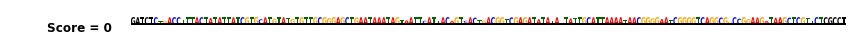

Pattern 1 (PWM & One-hot Sample)


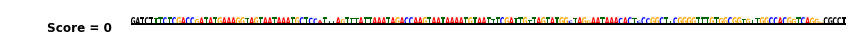

Pattern 2 (PWM & One-hot Sample)


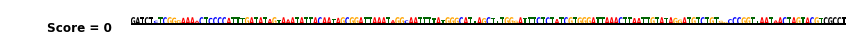

Pattern 3 (PWM & One-hot Sample)


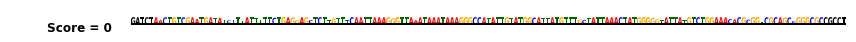

Pattern 4 (PWM & One-hot Sample)


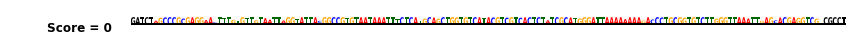

Epoch 2/25
Data index (train) = [42200 76296 30447 ... 67162 39038 73266]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 0.6141866
- Entropy Train Loss = 0.0016430208
- Discriminator Train Loss (real) = -0.29232746
- Discriminator Train Loss (fake) = -0.36370668
- Discriminator Train Loss (grad) = 0.03995288
Testing for epoch 2:
- Generator Valid Loss = 5.355668
- Entropy Valid Loss = 0.0010840853
- Discriminator Valid Loss (real) = 4.632194
- Discriminator Valid Loss (fake) = -5.3543496
- Discriminator Valid Loss (grad) = 0.06652435
- Discriminator Valid Score (real) = -4.632194
- Discriminator Valid Score (fake) = -5.3502884
- Discriminator Correct % = 87.88
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


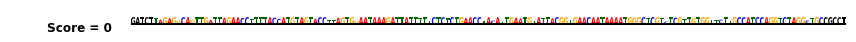

Pattern 1 (PWM & One-hot Sample)


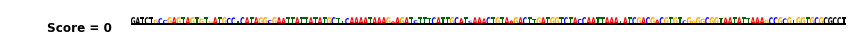

Pattern 2 (PWM & One-hot Sample)


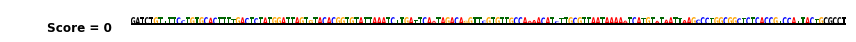

Pattern 3 (PWM & One-hot Sample)


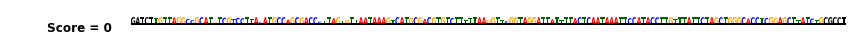

Pattern 4 (PWM & One-hot Sample)


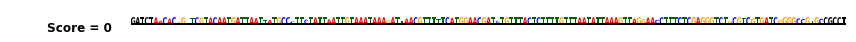

Epoch 3/25
Data index (train) = [53100 30553 38824 ... 23894 15331 19546]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 1.0524118
- Entropy Train Loss = 0.00073653506
- Discriminator Train Loss (real) = 0.48759344
- Discriminator Train Loss (fake) = -0.9260875
- Discriminator Train Loss (grad) = 0.028187754
Testing for epoch 3:
- Generator Valid Loss = 7.160229
- Entropy Valid Loss = 0.00044371377
- Discriminator Valid Loss (real) = 6.7751865
- Discriminator Valid Loss (fake) = -7.1600122
- Discriminator Valid Loss (grad) = 0.037824664
- Discriminator Valid Score (real) = -6.775186
- Discriminator Valid Score (fake) = -7.1594114
- Discriminator Correct % = 73.85
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


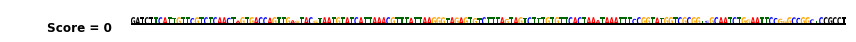

Pattern 1 (PWM & One-hot Sample)


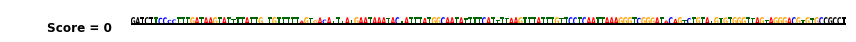

Pattern 2 (PWM & One-hot Sample)


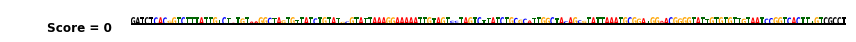

Pattern 3 (PWM & One-hot Sample)


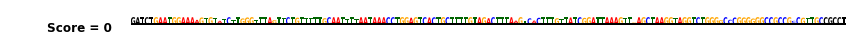

Pattern 4 (PWM & One-hot Sample)


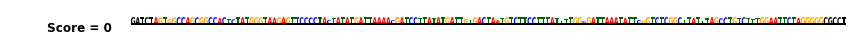

Epoch 4/25
Data index (train) = [16792 17635 56387 ... 70893 62302 11108]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 6.904985
- Entropy Train Loss = 0.00039575456
- Discriminator Train Loss (real) = 6.4115343
- Discriminator Train Loss (fake) = -6.7703657
- Discriminator Train Loss (grad) = 0.024865702
Testing for epoch 4:
- Generator Valid Loss = 4.824911
- Entropy Valid Loss = 0.00044248538
- Discriminator Valid Loss (real) = 4.4447675
- Discriminator Valid Loss (fake) = -4.82525
- Discriminator Valid Loss (grad) = 0.01895568
- Discriminator Valid Score (real) = -4.4447675
- Discriminator Valid Score (fake) = -4.827937
- Discriminator Correct % = 74.1
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


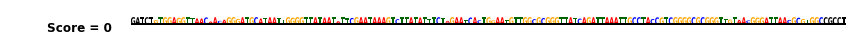

Pattern 1 (PWM & One-hot Sample)


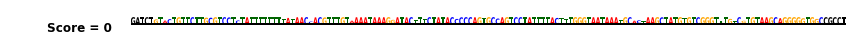

Pattern 2 (PWM & One-hot Sample)


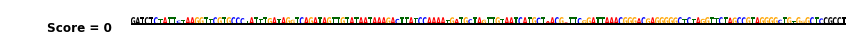

Pattern 3 (PWM & One-hot Sample)


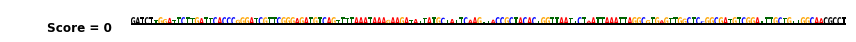

Pattern 4 (PWM & One-hot Sample)


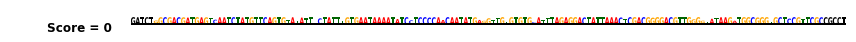

Epoch 5/25
Data index (train) = [77780  8087 48686 ... 46365   161 75385]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 5.314587
- Entropy Train Loss = 0.00046723432
- Discriminator Train Loss (real) = 4.8760214
- Discriminator Train Loss (fake) = -5.1937323
- Discriminator Train Loss (grad) = 0.021912662
Testing for epoch 5:
- Generator Valid Loss = -0.7554835
- Entropy Valid Loss = 0.0003590721
- Discriminator Valid Loss (real) = -0.9154469
- Discriminator Valid Loss (fake) = 0.75379306
- Discriminator Valid Loss (grad) = 0.023035184
- Discriminator Valid Score (real) = 0.9154469
- Discriminator Valid Score (fake) = 0.7543639
- Discriminator Correct % = 60.51
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


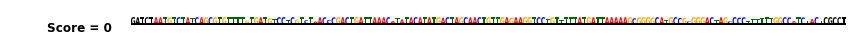

Pattern 1 (PWM & One-hot Sample)


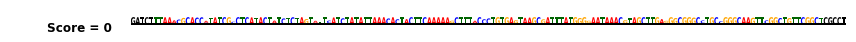

Pattern 2 (PWM & One-hot Sample)


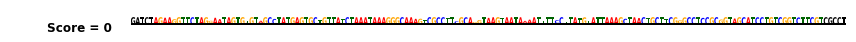

Pattern 3 (PWM & One-hot Sample)


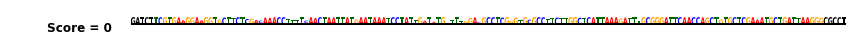

Pattern 4 (PWM & One-hot Sample)


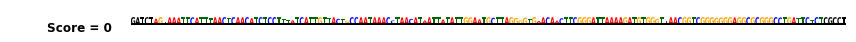

Epoch 6/25
Data index (train) = [21431 55130 48712 ... 25917 42658  8758]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 0.9365306
- Entropy Train Loss = 0.0003514086
- Discriminator Train Loss (real) = 0.5779439
- Discriminator Train Loss (fake) = -0.8464989
- Discriminator Train Loss (grad) = 0.0190187
Testing for epoch 6:
- Generator Valid Loss = -9.237134
- Entropy Valid Loss = 0.00036595043
- Discriminator Valid Loss (real) = -9.509708
- Discriminator Valid Loss (fake) = 9.239178
- Discriminator Valid Loss (grad) = 0.026150266
- Discriminator Valid Score (real) = 9.509708
- Discriminator Valid Score (fake) = 9.237934
- Discriminator Correct % = 66.48
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


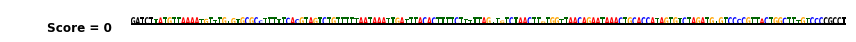

Pattern 1 (PWM & One-hot Sample)


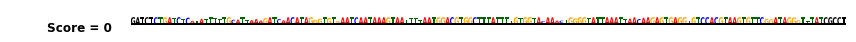

Pattern 2 (PWM & One-hot Sample)


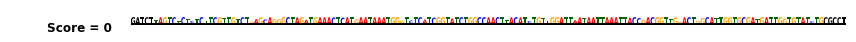

Pattern 3 (PWM & One-hot Sample)


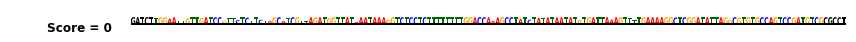

Pattern 4 (PWM & One-hot Sample)


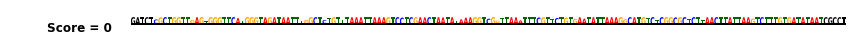

Epoch 7/25
Data index (train) = [67111  1371 56424 ... 60968 24018 56081]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = -2.0473568
- Entropy Train Loss = 0.00038928373
- Discriminator Train Loss (real) = -2.3744555
- Discriminator Train Loss (fake) = 2.1237218
- Discriminator Train Loss (grad) = 0.019168705
Testing for epoch 7:
- Generator Valid Loss = 11.728902
- Entropy Valid Loss = 0.00018778784
- Discriminator Valid Loss (real) = 11.563787
- Discriminator Valid Loss (fake) = -11.729042
- Discriminator Valid Loss (grad) = 0.019417876
- Discriminator Valid Score (real) = -11.563787
- Discriminator Valid Score (fake) = -11.726389
- Discriminator Correct % = 59.92
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


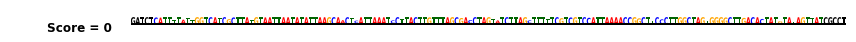

Pattern 1 (PWM & One-hot Sample)


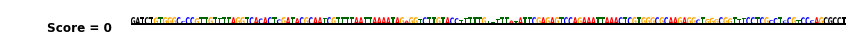

Pattern 2 (PWM & One-hot Sample)


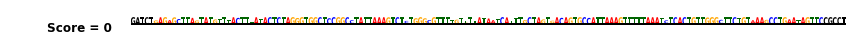

Pattern 3 (PWM & One-hot Sample)


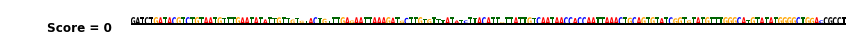

Pattern 4 (PWM & One-hot Sample)


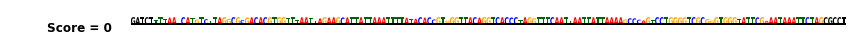

Epoch 8/25
Data index (train) = [57594 28790 74187 ...  8561 79668 66345]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = -0.20470007
- Entropy Train Loss = 0.00013993976
- Discriminator Train Loss (real) = -0.5162479
- Discriminator Train Loss (fake) = 0.2688868
- Discriminator Train Loss (grad) = 0.018674519
Testing for epoch 8:
- Generator Valid Loss = 5.205711
- Entropy Valid Loss = 0.00013171046
- Discriminator Valid Loss (real) = 4.999151
- Discriminator Valid Loss (fake) = -5.2043447
- Discriminator Valid Loss (grad) = 0.025393201
- Discriminator Valid Score (real) = -4.999151
- Discriminator Valid Score (fake) = -5.197311
- Discriminator Correct % = 63.8
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


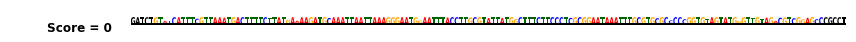

Pattern 1 (PWM & One-hot Sample)


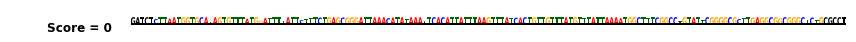

Pattern 2 (PWM & One-hot Sample)


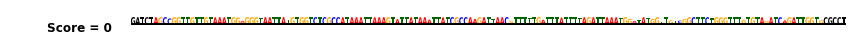

Pattern 3 (PWM & One-hot Sample)


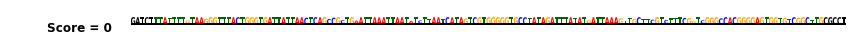

Pattern 4 (PWM & One-hot Sample)


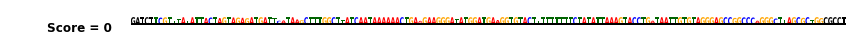

Epoch 9/25
Data index (train) = [38953 29338 37017 ... 60838 12411   409]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 0.30123937
- Entropy Train Loss = 0.00011938256
- Discriminator Train Loss (real) = 0.0012379028
- Discriminator Train Loss (fake) = -0.23290063
- Discriminator Train Loss (grad) = 0.016145071
Testing for epoch 9:
- Generator Valid Loss = 4.6866007
- Entropy Valid Loss = 0.0002039327
- Discriminator Valid Loss (real) = 4.481197
- Discriminator Valid Loss (fake) = -4.6881533
- Discriminator Valid Loss (grad) = 0.011186027
- Discriminator Valid Score (real) = -4.481197
- Discriminator Valid Score (fake) = -4.6898165
- Discriminator Correct % = 64.47
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


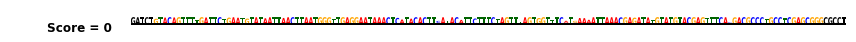

Pattern 1 (PWM & One-hot Sample)


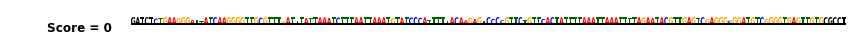

Pattern 2 (PWM & One-hot Sample)


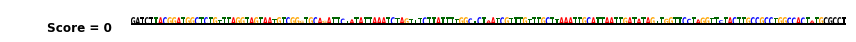

Pattern 3 (PWM & One-hot Sample)


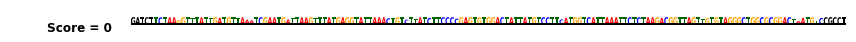

Pattern 4 (PWM & One-hot Sample)


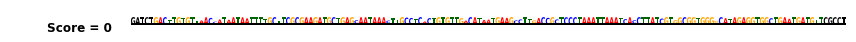

Epoch 10/25
Data index (train) = [40818 13699 14649 ... 21874 19114 11067]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 0.3761328
- Entropy Train Loss = 9.7883465e-05
- Discriminator Train Loss (real) = 0.08776645
- Discriminator Train Loss (fake) = -0.32246065
- Discriminator Train Loss (grad) = 0.017843572
Testing for epoch 10:
- Generator Valid Loss = -8.228029
- Entropy Valid Loss = 0.00014515652
- Discriminator Valid Loss (real) = -8.344427
- Discriminator Valid Loss (fake) = 8.22785
- Discriminator Valid Loss (grad) = 0.02389551
- Discriminator Valid Score (real) = 8.344427
- Discriminator Valid Score (fake) = 8.220391
- Discriminator Correct % = 57.36
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


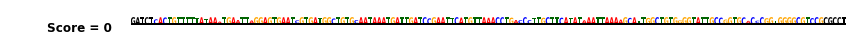

Pattern 1 (PWM & One-hot Sample)


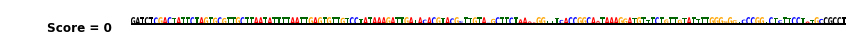

Pattern 2 (PWM & One-hot Sample)


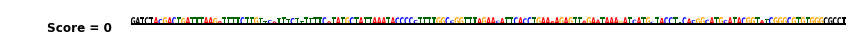

Pattern 3 (PWM & One-hot Sample)


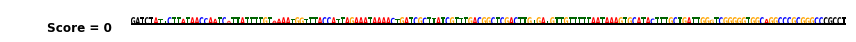

Pattern 4 (PWM & One-hot Sample)


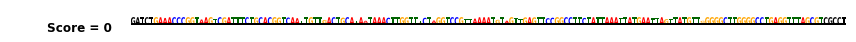

Epoch 11/25
Data index (train) = [12462 83766 49441 ... 26259 44536  5187]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 161s 32ms/step
- Generator Train Loss = 0.66731745
- Entropy Train Loss = 8.306578e-05
- Discriminator Train Loss (real) = 0.36922193
- Discriminator Train Loss (fake) = -0.59072536
- Discriminator Train Loss (grad) = 0.017000591
Testing for epoch 11:
- Generator Valid Loss = 3.4483454
- Entropy Valid Loss = 7.6903096e-05
- Discriminator Valid Loss (real) = 3.2735555
- Discriminator Valid Loss (fake) = -3.4443295
- Discriminator Valid Loss (grad) = 0.014213141
- Discriminator Valid Score (real) = -3.2735555
- Discriminator Valid Score (fake) = -3.4581687
- Discriminator Correct % = 61.85
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


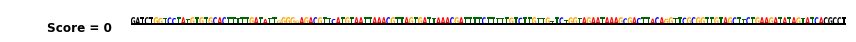

Pattern 1 (PWM & One-hot Sample)


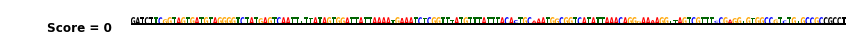

Pattern 2 (PWM & One-hot Sample)


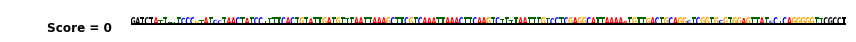

Pattern 3 (PWM & One-hot Sample)


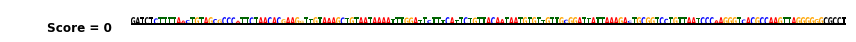

Pattern 4 (PWM & One-hot Sample)


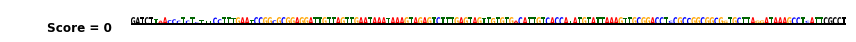

Epoch 12/25
Data index (train) = [73844 45498 71668 ... 58715 15744 57304]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 0.10485721
- Entropy Train Loss = 0.00018830698
- Discriminator Train Loss (real) = -0.17932795
- Discriminator Train Loss (fake) = -0.04314242
- Discriminator Train Loss (grad) = 0.01734598
Testing for epoch 12:
- Generator Valid Loss = 7.431861
- Entropy Valid Loss = 0.00018812106
- Discriminator Valid Loss (real) = 7.2810125
- Discriminator Valid Loss (fake) = -7.430592
- Discriminator Valid Loss (grad) = 0.014217343
- Discriminator Valid Score (real) = -7.2810116
- Discriminator Valid Score (fake) = -7.425842
- Discriminator Correct % = 59.77
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


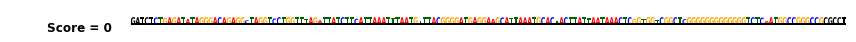

Pattern 1 (PWM & One-hot Sample)


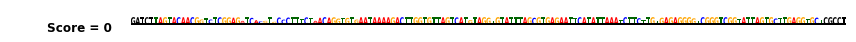

Pattern 2 (PWM & One-hot Sample)


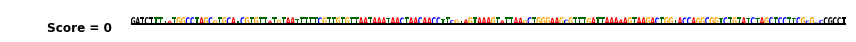

Pattern 3 (PWM & One-hot Sample)


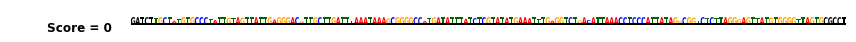

Pattern 4 (PWM & One-hot Sample)


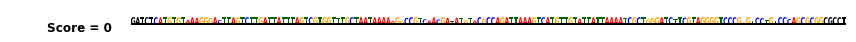

Epoch 13/25
Data index (train) = [82701 67710 36173 ... 14363  7972 71073]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 162s 32ms/step
- Generator Train Loss = 0.505782
- Entropy Train Loss = 0.00031101378
- Discriminator Train Loss (real) = 0.24110913
- Discriminator Train Loss (fake) = -0.44832587
- Discriminator Train Loss (grad) = 0.01683949
Testing for epoch 13:
- Generator Valid Loss = 2.9438112
- Entropy Valid Loss = 0.00030330473
- Discriminator Valid Loss (real) = 2.8358371
- Discriminator Valid Loss (fake) = -2.944022
- Discriminator Valid Loss (grad) = 0.015260143
- Discriminator Valid Score (real) = -2.8358371
- Discriminator Valid Score (fake) = -2.9441693
- Discriminator Correct % = 56.86
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


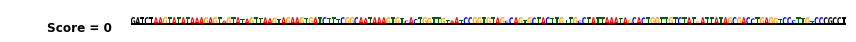

Pattern 1 (PWM & One-hot Sample)


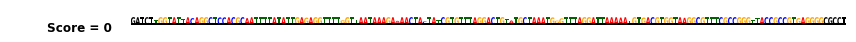

Pattern 2 (PWM & One-hot Sample)


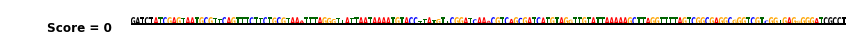

Pattern 3 (PWM & One-hot Sample)


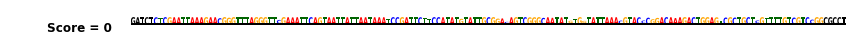

Pattern 4 (PWM & One-hot Sample)


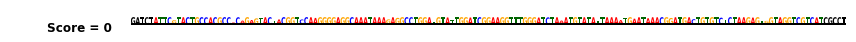

Epoch 14/25
Data index (train) = [28877 29890 17133 ... 41613 62150 75735]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 151s 30ms/step
- Generator Train Loss = 1.1890678
- Entropy Train Loss = 0.00037253872
- Discriminator Train Loss (real) = 0.9252631
- Discriminator Train Loss (fake) = -1.1477033
- Discriminator Train Loss (grad) = 0.0201634
Testing for epoch 14:
- Generator Valid Loss = -3.206921
- Entropy Valid Loss = 0.00038960006
- Discriminator Valid Loss (real) = -3.4820607
- Discriminator Valid Loss (fake) = 3.2059002
- Discriminator Valid Loss (grad) = 0.019382227
- Discriminator Valid Score (real) = 3.4820607
- Discriminator Valid Score (fake) = 3.2009947
- Discriminator Correct % = 67.2
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


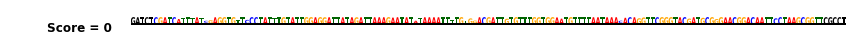

Pattern 1 (PWM & One-hot Sample)


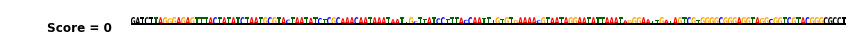

Pattern 2 (PWM & One-hot Sample)


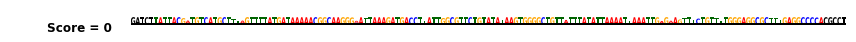

Pattern 3 (PWM & One-hot Sample)


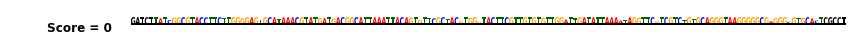

Pattern 4 (PWM & One-hot Sample)


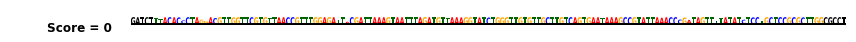

Epoch 15/25
Data index (train) = [73111 82721 39384 ... 51278 59258  6113]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 132s 26ms/step
- Generator Train Loss = -0.08412594
- Entropy Train Loss = 0.00017307392
- Discriminator Train Loss (real) = -0.35604268
- Discriminator Train Loss (fake) = 0.12850666
- Discriminator Train Loss (grad) = 0.020795193
Testing for epoch 15:
- Generator Valid Loss = -7.974038
- Entropy Valid Loss = 0.00024556095
- Discriminator Valid Loss (real) = -8.149944
- Discriminator Valid Loss (fake) = 7.9767904
- Discriminator Valid Loss (grad) = 0.024032705
- Discriminator Valid Score (real) = 8.149945
- Discriminator Valid Score (fake) = 7.952858
- Discriminator Correct % = 62.86
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


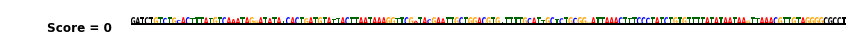

Pattern 1 (PWM & One-hot Sample)


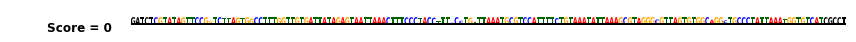

Pattern 2 (PWM & One-hot Sample)


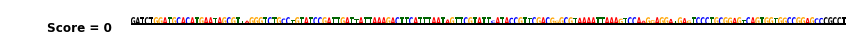

Pattern 3 (PWM & One-hot Sample)


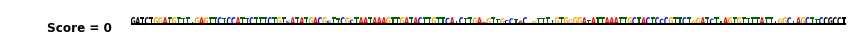

Pattern 4 (PWM & One-hot Sample)


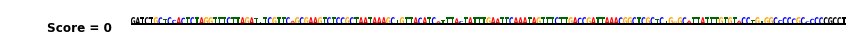

Epoch 16/25
Data index (train) = [24795 53000 18079 ... 80312 64219  2959]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 0.14797577
- Entropy Train Loss = 0.0003222347
- Discriminator Train Loss (real) = -0.12443965
- Discriminator Train Loss (fake) = -0.09843491
- Discriminator Train Loss (grad) = 0.02086985
Testing for epoch 16:
- Generator Valid Loss = 0.87781286
- Entropy Valid Loss = 0.00015334485
- Discriminator Valid Loss (real) = 0.64553785
- Discriminator Valid Loss (fake) = -0.8771354
- Discriminator Valid Loss (grad) = 0.027437933
- Discriminator Valid Score (real) = -0.64553785
- Discriminator Valid Score (fake) = -0.8847042
- Discriminator Correct % = 64.77
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


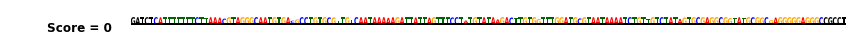

Pattern 1 (PWM & One-hot Sample)


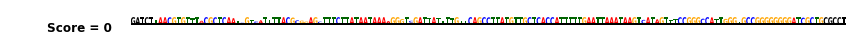

Pattern 2 (PWM & One-hot Sample)


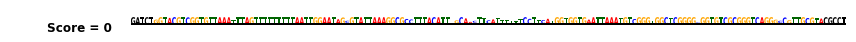

Pattern 3 (PWM & One-hot Sample)


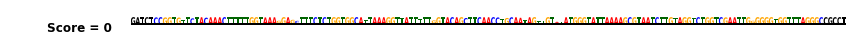

Pattern 4 (PWM & One-hot Sample)


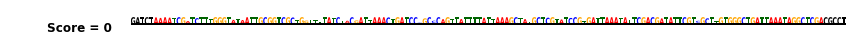

Epoch 17/25
Data index (train) = [36846 79914 77466 ... 10242 40517 84900]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 1.4956452
- Entropy Train Loss = 0.00034365835
- Discriminator Train Loss (real) = 1.2153568
- Discriminator Train Loss (fake) = -1.4418006
- Discriminator Train Loss (grad) = 0.023060467
Testing for epoch 17:
- Generator Valid Loss = 3.7493892
- Entropy Valid Loss = 0.00025339634
- Discriminator Valid Loss (real) = 3.5363696
- Discriminator Valid Loss (fake) = -3.7498946
- Discriminator Valid Loss (grad) = 0.018631104
- Discriminator Valid Score (real) = -3.5363696
- Discriminator Valid Score (fake) = -3.7647111
- Discriminator Correct % = 63.61
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


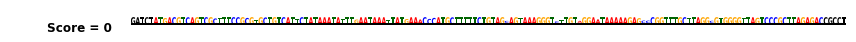

Pattern 1 (PWM & One-hot Sample)


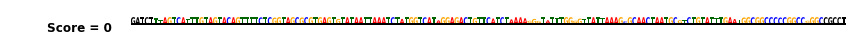

Pattern 2 (PWM & One-hot Sample)


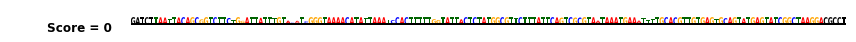

Pattern 3 (PWM & One-hot Sample)


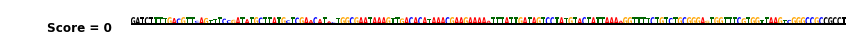

Pattern 4 (PWM & One-hot Sample)


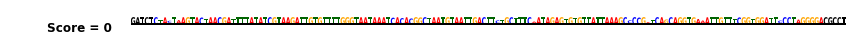

Epoch 18/25
Data index (train) = [65559 37972 76789 ... 58373 30003 61768]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 0.081832916
- Entropy Train Loss = 0.00035617253
- Discriminator Train Loss (real) = -0.17702773
- Discriminator Train Loss (fake) = -0.043127686
- Discriminator Train Loss (grad) = 0.022175357
Testing for epoch 18:
- Generator Valid Loss = 1.9493674
- Entropy Valid Loss = 0.0004042724
- Discriminator Valid Loss (real) = 1.701813
- Discriminator Valid Loss (fake) = -1.9502658
- Discriminator Valid Loss (grad) = 0.014814108
- Discriminator Valid Score (real) = -1.701813
- Discriminator Valid Score (fake) = -1.952836
- Discriminator Correct % = 66.28
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


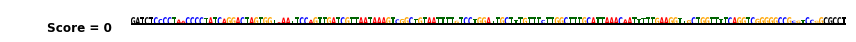

Pattern 1 (PWM & One-hot Sample)


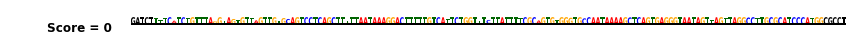

Pattern 2 (PWM & One-hot Sample)


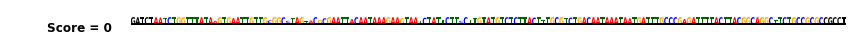

Pattern 3 (PWM & One-hot Sample)


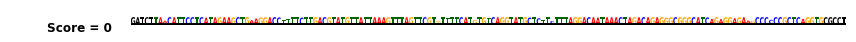

Pattern 4 (PWM & One-hot Sample)


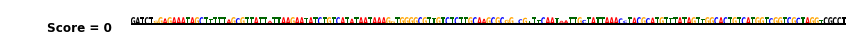

Epoch 19/25
Data index (train) = [71929 75358 41333 ... 48082 68059 39889]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 1.9713469
- Entropy Train Loss = 0.00020602474
- Discriminator Train Loss (real) = 1.7116953
- Discriminator Train Loss (fake) = -1.9269595
- Discriminator Train Loss (grad) = 0.022167856
Testing for epoch 19:
- Generator Valid Loss = 0.90047604
- Entropy Valid Loss = 0.00021741004
- Discriminator Valid Loss (real) = 0.70678467
- Discriminator Valid Loss (fake) = -0.8987977
- Discriminator Valid Loss (grad) = 0.016429888
- Discriminator Valid Score (real) = -0.70678467
- Discriminator Valid Score (fake) = -0.91178024
- Discriminator Correct % = 62.86
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


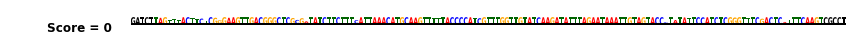

Pattern 1 (PWM & One-hot Sample)


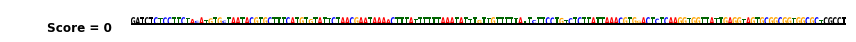

Pattern 2 (PWM & One-hot Sample)


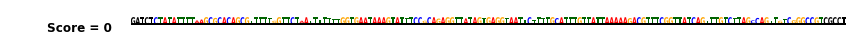

Pattern 3 (PWM & One-hot Sample)


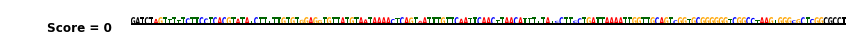

Pattern 4 (PWM & One-hot Sample)


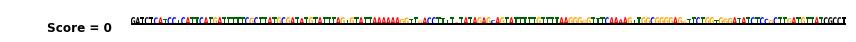

Epoch 20/25
Data index (train) = [77565 27164 55900 ... 67638 56264 32496]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 2.9526303
- Entropy Train Loss = 0.00011961118
- Discriminator Train Loss (real) = 2.6977112
- Discriminator Train Loss (fake) = -2.8966727
- Discriminator Train Loss (grad) = 0.020909736
Testing for epoch 20:
- Generator Valid Loss = 10.902965
- Entropy Valid Loss = 0.0001449649
- Discriminator Valid Loss (real) = 10.882055
- Discriminator Valid Loss (fake) = -10.898435
- Discriminator Valid Loss (grad) = 0.015158157
- Discriminator Valid Score (real) = -10.882055
- Discriminator Valid Score (fake) = -10.908614
- Discriminator Correct % = 52.08
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


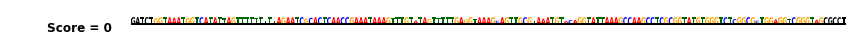

Pattern 1 (PWM & One-hot Sample)


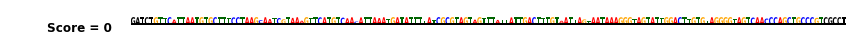

Pattern 2 (PWM & One-hot Sample)


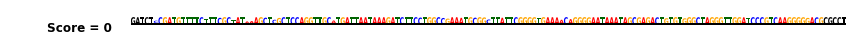

Pattern 3 (PWM & One-hot Sample)


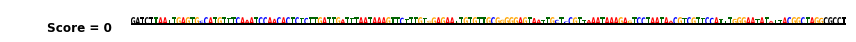

Pattern 4 (PWM & One-hot Sample)


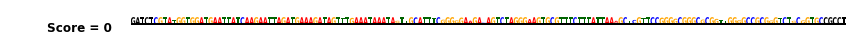

Epoch 21/25
Data index (train) = [53848 12265 85290 ... 48786   122 10986]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 1.9148415
- Entropy Train Loss = 8.636963e-05
- Discriminator Train Loss (real) = 1.6777805
- Discriminator Train Loss (fake) = -1.8744234
- Discriminator Train Loss (grad) = 0.020912267
Testing for epoch 21:
- Generator Valid Loss = 7.421581
- Entropy Valid Loss = 0.00018413045
- Discriminator Valid Loss (real) = 7.1626105
- Discriminator Valid Loss (fake) = -7.423099
- Discriminator Valid Loss (grad) = 0.02738507
- Discriminator Valid Score (real) = -7.1626105
- Discriminator Valid Score (fake) = -7.4190297
- Discriminator Correct % = 65.62
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


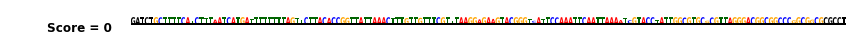

Pattern 1 (PWM & One-hot Sample)


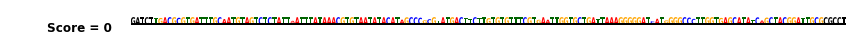

Pattern 2 (PWM & One-hot Sample)


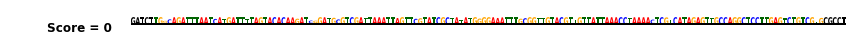

Pattern 3 (PWM & One-hot Sample)


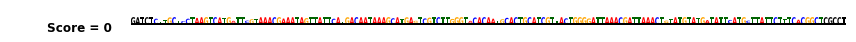

Pattern 4 (PWM & One-hot Sample)


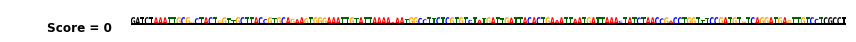

Epoch 22/25
Data index (train) = [27128 20125 75651 ... 19835 47031 15489]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = -0.4434662
- Entropy Train Loss = 5.7723046e-05
- Discriminator Train Loss (real) = -0.67445916
- Discriminator Train Loss (fake) = 0.48230782
- Discriminator Train Loss (grad) = 0.020807879
Testing for epoch 22:
- Generator Valid Loss = 5.300617
- Entropy Valid Loss = 4.1501935e-05
- Discriminator Valid Loss (real) = 4.9363823
- Discriminator Valid Loss (fake) = -5.300057
- Discriminator Valid Loss (grad) = 0.03314578
- Discriminator Valid Score (real) = -4.9363823
- Discriminator Valid Score (fake) = -5.2995853
- Discriminator Correct % = 71.1
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


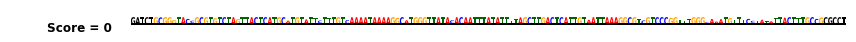

Pattern 1 (PWM & One-hot Sample)


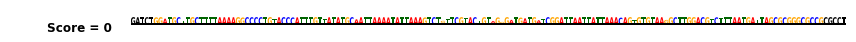

Pattern 2 (PWM & One-hot Sample)


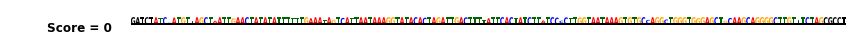

Pattern 3 (PWM & One-hot Sample)


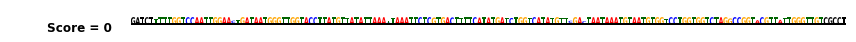

Pattern 4 (PWM & One-hot Sample)


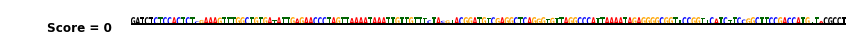

Epoch 23/25
Data index (train) = [59116 48026 72004 ... 60467  4547  9144]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 2.5783627
- Entropy Train Loss = 0.00014431197
- Discriminator Train Loss (real) = 2.3415635
- Discriminator Train Loss (fake) = -2.5405614
- Discriminator Train Loss (grad) = 0.02167753
Testing for epoch 23:
- Generator Valid Loss = 3.7049303
- Entropy Valid Loss = 0.00010155411
- Discriminator Valid Loss (real) = 3.6194725
- Discriminator Valid Loss (fake) = -3.7043555
- Discriminator Valid Loss (grad) = 0.018020375
- Discriminator Valid Score (real) = -3.6194725
- Discriminator Valid Score (fake) = -3.7117171
- Discriminator Correct % = 55.79
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


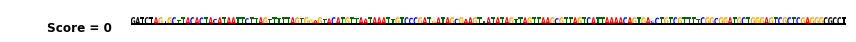

Pattern 1 (PWM & One-hot Sample)


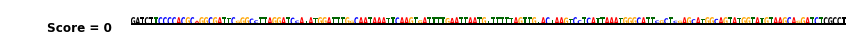

Pattern 2 (PWM & One-hot Sample)


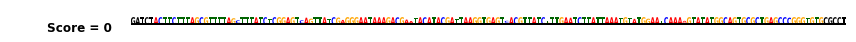

Pattern 3 (PWM & One-hot Sample)


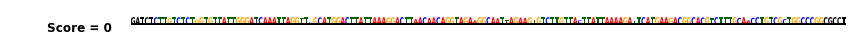

Pattern 4 (PWM & One-hot Sample)


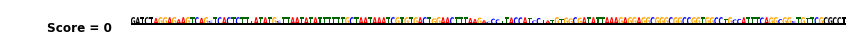

Epoch 24/25
Data index (train) = [ 5201 55123 61850 ... 82152 49719 77569]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 131s 26ms/step
- Generator Train Loss = 0.52111536
- Entropy Train Loss = 7.462736e-05
- Discriminator Train Loss (real) = 0.29099238
- Discriminator Train Loss (fake) = -0.48683456
- Discriminator Train Loss (grad) = 0.022076558
Testing for epoch 24:
- Generator Valid Loss = -3.903706
- Entropy Valid Loss = 4.866179e-06
- Discriminator Valid Loss (real) = -4.2232018
- Discriminator Valid Loss (fake) = 3.9028697
- Discriminator Valid Loss (grad) = 0.019707084
- Discriminator Valid Score (real) = 4.2232018
- Discriminator Valid Score (fake) = 3.9082606
- Discriminator Correct % = 69.06
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


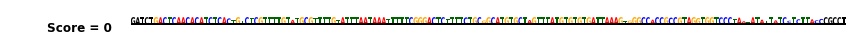

Pattern 1 (PWM & One-hot Sample)


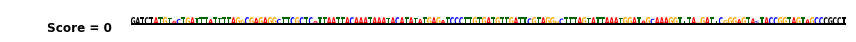

Pattern 2 (PWM & One-hot Sample)


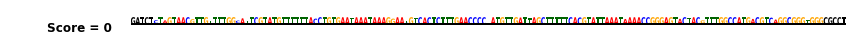

Pattern 3 (PWM & One-hot Sample)


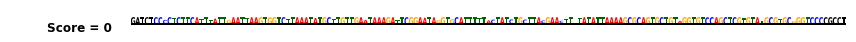

Pattern 4 (PWM & One-hot Sample)


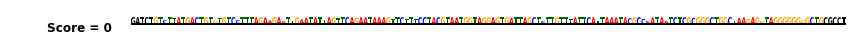

Epoch 25/25
Data index (train) = [15136 78743  8228 ... 58651 56001 28876]
Entropy anneal coeff. = 1.0
5000/5000 [==============================] - 132s 26ms/step
- Generator Train Loss = 2.9200222
- Entropy Train Loss = 2.34693e-05
- Discriminator Train Loss (real) = 2.6838915
- Discriminator Train Loss (fake) = -2.8785026
- Discriminator Train Loss (grad) = 0.022269582
Testing for epoch 25:
- Generator Valid Loss = 5.3344326
- Entropy Valid Loss = 2.3641742e-05
- Discriminator Valid Loss (real) = 4.9788313
- Discriminator Valid Loss (fake) = -5.3366017
- Discriminator Valid Loss (grad) = 0.029591022
- Discriminator Valid Score (real) = -4.9788313
- Discriminator Valid Score (fake) = -5.3351235
- Discriminator Correct % = 70.41
- Fake Patterns (Randomly Generated) -
Pattern 0 (PWM & One-hot Sample)


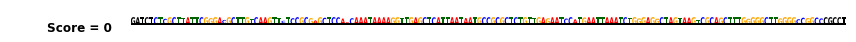

Pattern 1 (PWM & One-hot Sample)


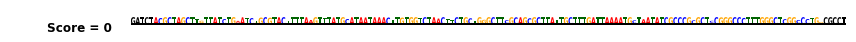

Pattern 2 (PWM & One-hot Sample)


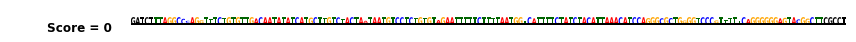

Pattern 3 (PWM & One-hot Sample)


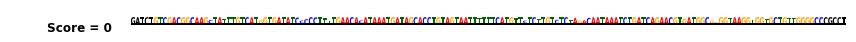

Pattern 4 (PWM & One-hot Sample)


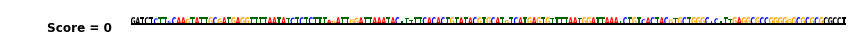

In [23]:

from_epoch = 1

n_epochs = 25

n_iters = 5000

validation_frequency = 1000

training_ratio = 5

verbose = True
verbose_n_pwms, verbose_n_samples = 5, 0

#Specify entropy anneal function
entropy_anneal_func = lambda epoch: 1.0

max_n_valid_batches = 200

epoch_train_history = defaultdict(list)
epoch_valid_history = defaultdict(list)
valid_history = defaultdict(list)

for epoch in range(from_epoch, n_epochs + 1) :
    print('Epoch {}/{}'.format(epoch, n_epochs))
    print("Data index (train) = " + str(data_gens['train'].indexes))

    progress_bar = Progbar(target=n_iters)

    K.set_value(entropy_anneal_coeff, entropy_anneal_func(epoch - 1))
    
    print("Entropy anneal coeff. = " + str(round(K.get_value(entropy_anneal_coeff), 3)))
    
    gen_train_losses = []
    ent_train_losses = []
    
    disc_real_train_losses = []
    disc_fake_train_losses = []
    disc_gp_train_losses = []
    
    for index in range(1, n_iters + 1) :
        sequence_batch = data_gens['train'][(index - 1) % len(data_gens['train'])][0][0]
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, real_l, fake_l, gp_l = discriminator_model_real_data.train_on_batch(
            [class_batch, seed_batch, sequence_batch],
            [dummy_data_target, dummy_data_target, dummy_data_target]
        )
        
        disc_real_train_losses.append(real_l)
        disc_fake_train_losses.append(fake_l)
        disc_gp_train_losses.append(gp_l)
        
        if index % training_ratio == 0 :
            
            class_batch = np.zeros((batch_size, 1), dtype=np.int)
            seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
            
            _, gen_l, ent_l = discriminator_model_fake_data.train_on_batch(
                [class_batch, seed_batch],
                [dummy_data_target, dummy_data_target]
            )
            
            gen_train_losses.append(gen_l)
            ent_train_losses.append(ent_l)
        
        if index % validation_frequency == 0 :
            evaluate_gan(data_gens['valid'], generator_model, discriminator_model, valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
        
        progress_bar.update(index)
    
    gen_train_loss = np.mean(np.array(gen_train_losses), axis=0)
    ent_train_loss = np.mean(np.array(ent_train_losses), axis=0)
    
    disc_real_train_loss = np.mean(np.array(disc_real_train_losses), axis=0)
    disc_fake_train_loss = np.mean(np.array(disc_fake_train_losses), axis=0)
    disc_gp_train_loss = np.mean(np.array(disc_gp_train_losses), axis=0)
    
    epoch_train_history['generator_loss'].append(gen_train_loss)
    epoch_train_history['entropy_loss'].append(ent_train_loss)
    epoch_train_history['discriminator_real_loss'].append(disc_real_train_loss)
    epoch_train_history['discriminator_fake_loss'].append(disc_fake_train_loss)
    epoch_train_history['discriminator_gp_loss'].append(disc_gp_train_loss)
    
    print("- Generator Train Loss = " + str(gen_train_loss))
    print("- Entropy Train Loss = " + str(ent_train_loss))
    print("- Discriminator Train Loss (real) = " + str(disc_real_train_loss))
    print("- Discriminator Train Loss (fake) = " + str(disc_fake_train_loss))
    print("- Discriminator Train Loss (grad) = " + str(disc_gp_train_loss))
    
    
    print('Testing for epoch {}:'.format(epoch))
    
    evaluate_gan_loss(data_gens['valid'], discriminator_model_fake_data, discriminator_model_real_data, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Generator Valid Loss = " + str(epoch_valid_history['generator_loss'][-1]))
    print("- Entropy Valid Loss = " + str(epoch_valid_history['entropy_loss'][-1]))
    print("- Discriminator Valid Loss (real) = " + str(epoch_valid_history['discriminator_real_loss'][-1]))
    print("- Discriminator Valid Loss (fake) = " + str(epoch_valid_history['discriminator_fake_loss'][-1]))
    print("- Discriminator Valid Loss (grad) = " + str(epoch_valid_history['discriminator_gp_loss'][-1]))
    
    evaluate_gan(data_gens['valid'], generator_model, discriminator_model, epoch_valid_history, batch_size=batch_size, max_n_valid_batches=max_n_valid_batches)
    
    print("- Discriminator Valid Score (real) = " + str(epoch_valid_history['discriminator_real_score'][-1]))
    print("- Discriminator Valid Score (fake) = " + str(epoch_valid_history['discriminator_fake_score'][-1]))
    print("- Discriminator Correct % = " + str(round(epoch_valid_history['discriminator_accuracy'][-1] * 100, 2)))

    if verbose :
    
        print("- Fake Patterns (Randomly Generated) -")
        
        class_batch = np.zeros((batch_size, 1), dtype=np.int)
        seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
        
        _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch(x=[class_batch, seed_batch])

        for plot_i in range(min(verbose_n_pwms, batch_size)) :
            print('Pattern ' + str(plot_i) + ' (PWM & One-hot Sample)')
            plot_gan_logo(fake_pwm_batch[plot_i, 0, :, :], 0, sequence_template=sequence_templates[0], figsize=(12, 0.5), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)
            
    data_gens['train'].on_epoch_end()


--- Training Losses ---

(Generator Losses)


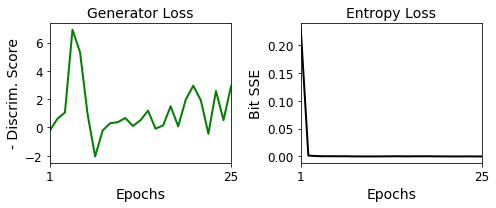

(Discriminator Losses)


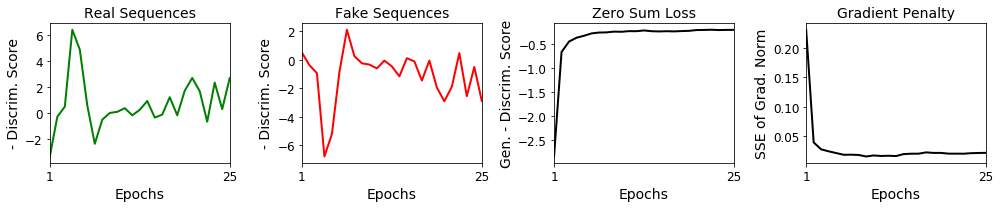

--- Validation Losses ---

(Generator Losses)


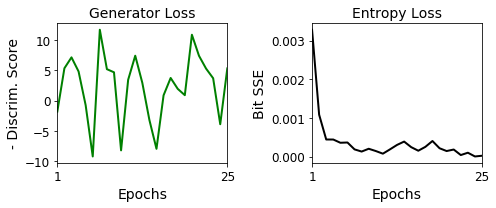

(Discriminator Losses)


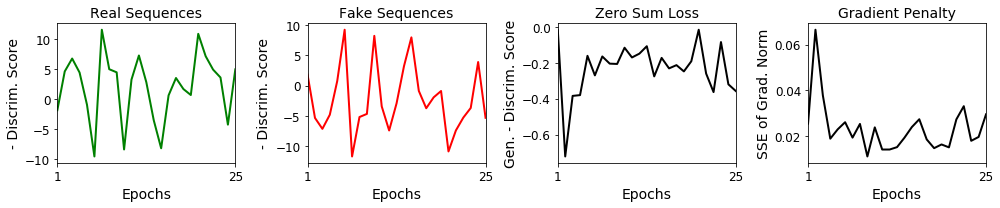

In [24]:

for eval_str, eval_history in [('Training', epoch_train_history), ('Validation', epoch_valid_history)] :

    print("--- " + eval_str + " Losses ---")
    print("")
    
    print("(Generator Losses)")
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(3.5 * 2, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['generator_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Generator Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['entropy_loss'], linewidth=2, color='black')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Bit SSE", fontsize=14)
    plt.title("Entropy Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()
    
    print("(Discriminator Losses)")

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

    ax1.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_real_loss'], linewidth=2, color='green')

    plt.sca(ax1)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Real Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax2.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_fake_loss'], linewidth=2, color='red')

    plt.sca(ax2)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("- Discrim. Score", fontsize=14)
    plt.title("Fake Sequences", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    ax3.plot(np.arange(1, n_epochs + 1), np.ravel(eval_history['discriminator_fake_loss']) + np.ravel(eval_history['discriminator_real_loss']), linewidth=2, color='black')

    plt.sca(ax3)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Gen. - Discrim. Score", fontsize=14)
    plt.title("Zero Sum Loss", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)
    
    ax4.plot(np.arange(1, n_epochs + 1), eval_history['discriminator_gp_loss'], linewidth=2, color='black')

    plt.sca(ax4)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("SSE of Grad. Norm", fontsize=14)
    plt.title("Gradient Penalty", fontsize=14)
    plt.xlim(1, n_epochs)
    plt.xticks([1, n_epochs], [1, n_epochs], fontsize=12)
    plt.yticks(fontsize=12)

    plt.tight_layout()

    plt.show()


Validation Metrics (Frequent)


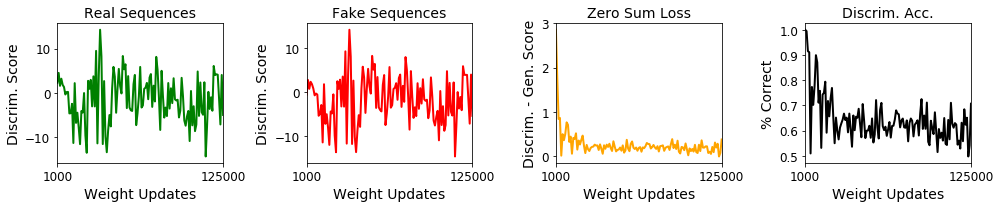

In [25]:
print("Validation Metrics (Frequent)")

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3.5 * 4, 3))

t = np.arange(1, len(valid_history['discriminator_real_score']) + 1) * validation_frequency

ax1.plot(t, valid_history['discriminator_real_score'], linewidth=2, color='green')

plt.sca(ax1)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Real Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(t, valid_history['discriminator_fake_score'], linewidth=2, color='red')

plt.sca(ax2)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. Score", fontsize=14)
plt.title("Fake Sequences", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(t, np.ravel(valid_history['discriminator_real_score']) - np.ravel(valid_history['discriminator_fake_score']), linewidth=2, color='orange')

plt.sca(ax3)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("Discrim. - Gen. Score", fontsize=14)
plt.title("Zero Sum Loss", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

ax4.plot(t, valid_history['discriminator_accuracy'], linewidth=2, color='black')

plt.sca(ax4)
plt.xlabel("Weight Updates", fontsize=14)
plt.ylabel("% Correct", fontsize=14)
plt.title("Discrim. Acc.", fontsize=14)
plt.xlim(t[0], t[-1])
plt.xticks([t[0], t[-1]], [t[0], t[-1]], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()

In [26]:
#Save model weights and evaluation metrics
save_dir = 'saved_models'

task_suffix = '_simple'

gen_suffix = '_gen_resnet_4_resblocks'
disc_suffix = '_disc_resnet_4_resblocks'

train_suffix = '_wgan_singlesample_batchnorm_trainmode_instancenorm'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_discriminator.h5'
model_path = os.path.join(save_dir, model_name)
discriminator_model.save(model_path)
print('Saved trained model at %s ' % model_path)


metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_train_history.pickle'
pickle.dump(epoch_train_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_epoch_valid_history.pickle'
pickle.dump(epoch_valid_history, open(metric_name, 'wb'))

metric_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_valid_history.pickle'
pickle.dump(valid_history, open(metric_name, 'wb'))

print('Stored metrics.')

Saved trained model at saved_models/gan_simple_gen_resnet_4_resblocks_disc_resnet_4_resblocks_wgan_singlesample_batchnorm_trainmode_instancenorm_generator.h5 
Saved trained model at saved_models/gan_simple_gen_resnet_4_resblocks_disc_resnet_4_resblocks_wgan_singlesample_batchnorm_trainmode_instancenorm_discriminator.h5 
Stored metrics.


- Fake Sequences (Randomly Generated) -


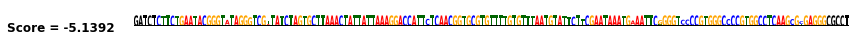

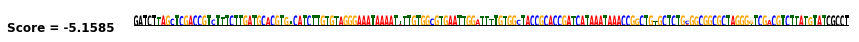

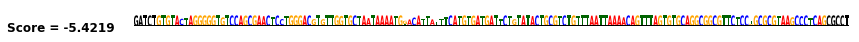

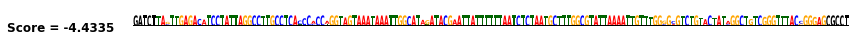

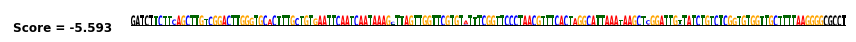

- Real Sequences (Randomly Sampled from Test Set) -


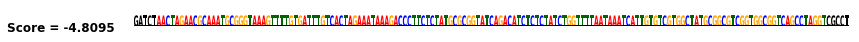

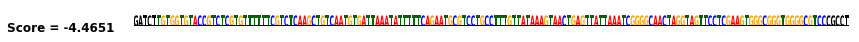

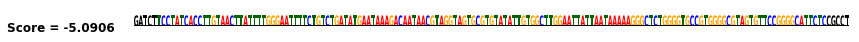

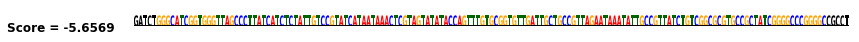

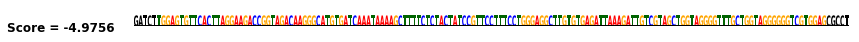

In [28]:
#Visualize a few fake and real sequence patterns

real_scores = []
real_sequences = []
fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(len(data_gens['test'])) :
    real_sequence_batch = data_gens['test'][test_index][0][0]
    real_score_batch = discriminator_model.predict_on_batch([real_sequence_batch])

    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    real_scores.append(real_score_batch)
    real_sequences.append(real_sequence_batch)
    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

real_scores = np.concatenate(real_scores, axis=0)
real_sequences = np.concatenate(real_sequences, axis=0)
fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(5) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)
    #plot_gan_logo(fake_sequences[plot_i, 0, :, :, 0], fake_scores[plot_i, 0, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)

print("- Real Sequences (Randomly Sampled from Test Set) -")

for plot_i in range(5) :
    plot_gan_logo(real_sequences[plot_i, 0, :, :], real_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=20, plot_end=177)
